# The module code:
The module should be quite independent of the rest of qpms, so there should be now no imports therefrom.
Therefore, it can be pasted (and modified and developed) below:

In [143]:
import numpy as np
from enum import Enum

nx = None

class LatticeType(Enum):
    """
    All the five Bravais lattices in 2D
    """
    OBLIQUE=1
    RECTANGULAR=2
    SQUARE=4
    RHOMBIC=5
    EQUILATERAL_TRIANGULAR=3
    RIGHT_ISOSCELES=SQUARE
    PARALLELOGRAMMIC=OBLIQUE
    CENTERED_RHOMBIC=RECTANGULAR
    RIGHT_TRIANGULAR=RECTANGULAR
    CENTERED_RECTANGULAR=RHOMBIC
    ISOSCELE_TRIANGULAR=RHOMBIC
    RIGHT_ISOSCELE_TRIANGULAR=SQUARE
    HEXAGONAL=EQUILATERAL_TRIANGULAR

def reduceBasisSingle(b1, b2):
    """
    Lagrange-Gauss reduction of a 2D basis.
    cf. https://www.math.auckland.ac.nz/~sgal018/crypto-book/ch17.pdf
    inputs and outputs are (2,)-shaped numpy arrays
    The output shall satisfy |b1| <= |b2| <= |b2 - b1| 
    TODO doc
    
    TODO perhaps have the (on-demand?) guarantee of obtuse angle between b1, b2?
    TODO possibility of returning the (in-order, no-obtuse angles) b as well?
    """
    b1 = np.array(b1)
    b2 = np.array(b2)
    if b1.shape != (2,) or b2.shape != (2,):
        raise ValueError('Shape of b1 and b2 must be (2,)')
    B1 = np.sum(b1 * b1, axis=-1, keepdims=True)
    mu = np.sum(b1 * b2, axis=-1, keepdims=True) / B1
    b2 = b2 - np.rint(mu) * b1
    B2 = np.sum(b2 * b2, axis=-1, keepdims=True)
    while(np.any(B2 < B1)):
        b2t = b1
        b1 = b2
        b2 = b2t
        B1 = B2
        mu = np.sum(b1 * b2, axis=-1, keepdims=True) / B1
        b2 = b2 - np.rint(mu) * b1
        B2 = np.sum(b2*b2, axis=-1, keepdims=True)
    return(b1,b2)

def shortestBase3(b1, b2):
    ''' 
    returns the "ordered shortest triple" of base vectors (each pair from 
    the triple is a base) and there may not be obtuse angle between b1, b2
    and between b2, b3
    '''
    b1, b2 = reduceBasisSingle(b1,b2)
    if is_obtuse(b1, b2, tolerance=0):
        b3 = b2
        b2 = b2 + b1
    else:
        b3 = b2 - b1
    return (b1, b2, b3)

def shortestBase46(b1, b2, tolerance=1e-13):
    b1, b2 = reduceBasisSingle(b1,b2)
    b1s = np.sum(b1 ** 2)
    b2s = np.sum(b2 ** 2)
    b3 = b2 - b1
    b3s = np.sum(b3 ** 2)
    eps = tolerance * (b2s + b1s)
    if abs(b3s - b2s - b1s) < eps:
        return(b1, b2, -b1, -b2)
    else:
        if b3s - b2s - b1s > eps: #obtuse
            b3 = b2
            b2 = b2 + b1
        return (b1, b2, b3, -b1, -b2, -b3)
    

def is_obtuse(b1, b2, tolerance=1e-13):
    b1s = np.sum(b1 ** 2)
    b2s = np.sum(b2 ** 2)
    b3 = b2 - b1
    b3s = np.sum(b3 ** 2)
    eps = tolerance * (b2s + b1s)
    return (b3s - b2s - b1s > eps)

def classifyLatticeSingle(b1, b2, tolerance=1e-13):
    """
    Given two basis vectors, returns 2D Bravais lattice type.
    Tolerance is relative.
    TODO doc
    """
    b1, b2 = reduceBasisSingle(b1, b2)
    b1s = np.sum(b1 ** 2)
    b2s = np.sum(b2 ** 2)
    b3 = b2 - b1
    b3s = np.sum(b3 ** 2)
    eps = tolerance * (b2s + b1s)
    # Avoid obtuse angle between b1 and b2. TODO This should be yet thoroughly tested.
    # TODO use is_obtuse here?
    if b3s - b2s - b1s > eps:
        b3 = b2
        b2 = b2 + b1
        # N. B. now the assumption |b3| >= |b2| is no longer valid
        #b3 = b2 - b1
        b2s = np.sum(b2 ** 2)
        b3s = np.sum(b3 ** 2)
    if abs(b2s - b1s) < eps or abs(b2s - b3s) < eps: # isoscele
        if abs(b3s - b1s) < eps:
            return LatticeType.EQUILATERAL_TRIANGULAR
        elif abs(b3s - 2 * b1s) < eps:
            return LatticeType.SQUARE
        else:
            return LatticeType.RHOMBIC
    elif abs(b3s - b2s - b1s) < eps:
        return LatticeType.RECTANGULAR
    else:
        return LatticeType.OBLIQUE

def range2D(maxN, mini=1, minj=0, minN = 0):
    """
    "Triangle indices"
    Generates pairs of non-negative integer indices (i, j) such that
    minN ≤ i + j ≤ maxN, i ≥ mini, j ≥ minj.
    TODO doc and possibly different orderings
    """
    for maxn in range(min(mini, minj, minN), floor(maxN+1)): # i + j == maxn
        for i in range(mini, maxn + 1):
            yield (i, maxn - i)

            
def generateLattice(b1, b2, maxlayer=5, include_origin=False, order='leaves'):
    bvs = shortestBase46(b1, b2)
    cc = len(bvs) # "corner count"
    
    if order == 'leaves':
        indices = np.array(list(range2D(maxlayer)))
        ia = indices[:,0]
        ib = indices[:,1]
        cc = len(bvs) # 4 for square/rec,
        leaves = list()
        if include_origin: leaves.append(np.array([[0,0]]))
        for c in range(cc):
            ba = bvs[c]
            bb = bvs[(c+1)%cc]
            leaves.append(ia[:,nx]*ba + ib[:,nx]*bb)
        return np.concatenate(leaves)
    else: 
        raise ValueError('Lattice point order not implemented: ', order)
        
def generateLatticeDisk(b1, b2, r, include_origin=False, order='leaves'):
    b1, b2 = reduceBasisSingle(b1,b2)
    blen = np.linalg.norm(b1, ord=2)
    maxlayer = 2*r/blen # FIXME kanon na vrabce? Nestačí odmocnina ze 2?
    points = generateLattice(b1,b2, maxlayer=maxlayer, include_origin=include_origin, order=order)
    mask = (np.linalg.norm(points, axis=-1, ord=2) <= r)
    return points[mask]

def cellCornersWS(b1, b2,):
    """
    Given basis vectors, returns the corners of the Wigner-Seitz unit cell
    (w1, w2, -w1, w2) for rectangular and square lattice or
    (w1, w2, w3, -w1, -w2, -w3) otherwise
    """
    def solveWS(v1, v2):
        v1x = v1[0]
        v1y = v1[1]
        v2x = v2[0]
        v2y = v2[1]
        lsm = ((-v1y, v2y), (v1x, -v2x))
        rs = ((v1x-v2x)/2, (v1y - v2y)/2)
        t = np.linalg.solve(lsm, rs)
        return np.array(v1)/2 + t[0]*np.array((v1y, -v1x))
    b1, b2 = reduceBasisSingle(b1, b2)
    latticeType = classifyLatticeSingle(b1, b2)
    if latticeType is LatticeType.RECTANGULAR or latticeType is LatticeType.SQUARE:
        return np.array( (
            (+b1+b2),
            (+b2-b1),
            (-b1-b2),
            (-b2+b1),
        )) / 2
    else:
        bvs = shortestBase46(b1,b2,tolerance=0)
        return np.array([solveWS(bvs[i], bvs[(i+1)%6]) for i in range(6)])

def cutWS(points, b1, b2, scale=1., tolerance=1e-13):
    """ 
    From given points, return only those that are inside (or on the edge of)
    the Wigner-Seitz cell of a (scale*b1, scale*b2)-based lattice.
    """
    # TODO check input dimensions?
    bvs = shortestBase46(b1, b2)
    points = np.array(points)
    for b in bvs: 
        mask = (np.tensordot(points, b, axes=(-1, 0)) <=  (scale * (1+tolerance) / 2) *np.linalg.norm(b, ord=2)**2 )
        points = points[mask]
    return points

def filledWS(b1, b2, density=10, scale=1.):
    """
    TODO doc
    TODO more intelligent generation, anisotropy balancing etc.
    """
    points = generateLattice(b1,b2,maxlayer=density*scale, include_origin=True)
    points = cutWS(points/density, np.array(b1)*scale, np.array(b2)*scale)
    return points
    
    
rot90_ = np.array([[0,1],[-1,0]])
def reciprocalBasis(a1, a2):
    a1, a2 = reduceBasisSingle(a1,a2) # this can be replaced with the vector version of reduceBasis when it is made
    prefac = 2*np.pi/np.sum(np.tensordot(a1, rot90_, axes=[-1,0]) * a2, axis=-1)
    b1 = np.tensordot(rot90_, a2, axes=[-1,-1]) * prefac
    b2 = np.tensordot(rot90_, a1, axes=[-1,-1]) * prefac
    return (b1, b2)


# TODO fill it with "points from reciprocal space" instead
def filledWS2(b1,b2, density=10, scale=1.):
    b1, b2 = reduceBasisSingle(b1,b2)
    b1r, b2r = reciprocalBasis(b1,b2)
    b1l = np.linalg.norm(b1, ord=2)
    b2l = np.linalg.norm(b2, ord=2)
    b1rl = np.linalg.norm(b1r, ord=2)
    b2rl = np.linalg.norm(b2r, ord=2)
    # Black magick. Think later.™ Really. FIXME
    sicher_ratio = np.maximum(b1rl/b2rl, b2rl/b1rl) * np.maximum(b1l/b2l, b2l/b1l) # This really has to be adjusted
    points = generateLattice(b1r,b2r,maxlayer=density*scale*sicher_ratio, include_origin=True)
    points = cutWS(points*b1l/b1rl/density, b1*scale, b2*scale)
    return points



"""
TODO
====

- DOC!!!!!
- (nehoří) výhledově pořešit problém „hodně anisotropních“ mřížek (tj. kompensovat
rozdílné délky základních vektorů).

"""

'\nTODO\n====\n\n- DOC!!!!!\n- (nehoří) výhledově pořešit problém „hodně anisotropních“ mřížek (tj. kompensovat\nrozdílné délky základních vektorů).\n\n'

# Playground:

## Lattice classification
TODO convert this to regular unit tests

In [144]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
bs = 100e-9
latsiz=5
from math import sin, cos, sqrt, floor
s2 = sqrt(2)
s3 = sqrt(3)
pi = np.pi

def draw_and_classify(b1, b2):
    f, ax = plt.subplots(figsize=(6,6))
    #points = generateLattice(b1,b2, maxlayer=latsiz,include_origin=True)
    points = generateLatticeDisk(b1,b2,bs*latsiz, include_origin=True)
    ax.plot(points[:,0], points[:,1], 'ko-', lw=0.3)
    ax.plot((0,b1[0]), (0, b1[1]), '--', label = 'b1 input')
    ax.plot((0,b2[0]), (0, b2[1]), '--', label = 'b2 input')
    #ax.arrow(0,0,b1[0], b1[1]) # arrows seem to be broken at this scale
    #ax.arrow(0,0,b2[0], b2[1])
    
    wsc = cellCornersWS(b1,b2)
    codesWS = [Path.MOVETO] + (len(wsc)-1)*[Path.LINETO] + [Path.CLOSEPOLY]
    vertsWS = list(wsc) + [wsc[0]]
    vertsWSbig = list(wsc*latsiz) + [wsc[0]]
    patchWSbig = patches.PathPatch(Path(vertsWSbig, codesWS), ls='--')
    patchWS = patches.PathPatch(Path(vertsWS, codesWS), facecolor='yellow')
    ax.add_patch(patchWSbig)
    ax.add_patch(patchWS)
    

    
    altorig = (3*b1[0], 3*b1[1])
    b1, b2 = reduceBasisSingle(b1,b2)
    pointsWS = filledWS(b1,b2, density=latsiz, scale=3)+2*b1+2*b2
    pointsWS2 = filledWS2(b1,b2, density=latsiz, scale=3)-2*b1-2*b2
    ax.plot(pointsWS[:,0], pointsWS[:,1], 'r.')
    ax.plot(pointsWS2[:,0], pointsWS2[:,1], 'g.')
    altorig = (3*b1[0], 3*b1[1])
    b3 = (b2[0]-b1[0], b2[1]-b1[1]) # yök
    ax.plot((altorig[0],altorig[0]+b1[0]), (altorig[1], altorig[1] + b1[1]), '--', label='b1 reduced')
    ax.plot((altorig[0],altorig[0]+b2[0]), (altorig[1], altorig[1] + b2[1]), '--', label='b2 reduced')
    ax.plot((altorig[0],altorig[0]+b3[0]), (altorig[1], altorig[1] + b3[1]), '--', label='b3 reduced')
    altorig = (3*b2[0], 3*b2[1])
    if is_obtuse(b1,b2):
        b1, b2, b3 = shortestBase3(b1, b2)
        ax.plot((altorig[0],altorig[0]+b1[0]), (altorig[1], altorig[1] + b1[1]), '--', label='b1 n/o')
        ax.plot((altorig[0],altorig[0]+b2[0]), (altorig[1], altorig[1] + b2[1]), '--', label='b2 n/o')
        ax.plot((altorig[0],altorig[0]+b3[0]), (altorig[1], altorig[1] + b3[1]), '--', label='b3 n/o')
    ax.legend()
    #ax.arrow(altorig[0],altorig[1],altorig[0]+b1[0], altorig[1]+b1[1])
    #ax.arrow(altorig[0],altorig[1],altorig[0]+b2[0], altorig[1]+b2[1])
    #ax.arrow(altorig[0],altorig[1],altorig[0]+b3[0], altorig[1]+b3[1])
    ax.set_aspect('equal')
    print(reciprocalBasis(b1,b2))
    print(reduceBasisSingle(*reciprocalBasis(b1,b2)))
    return classifyLatticeSingle(b1,b2)

### Square lattices

(array([       -0.        ,  62831853.07179587]), array([-62831853.07179587,        -0.        ]))
(array([       -0.        ,  62831853.07179587]), array([-62831853.07179587,        -0.        ]))


<LatticeType.SQUARE: 4>

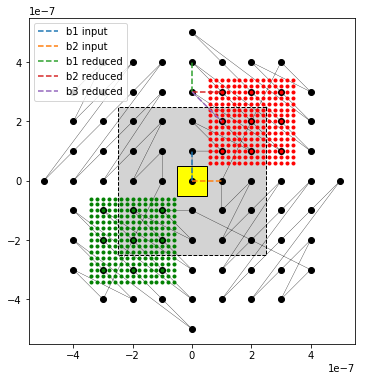

In [145]:
b1 = (0,bs)
b2 = (bs,0)
#classifyLatticeSingle(b1,b2)
draw_and_classify(b1, b2)

(array([ 31415926.53589794,  31415926.53589794]), array([ 31415926.53589794, -31415926.53589794]))
(array([ 31415926.53589794,  31415926.53589794]), array([ 31415926.53589794, -31415926.53589794]))


<LatticeType.SQUARE: 4>

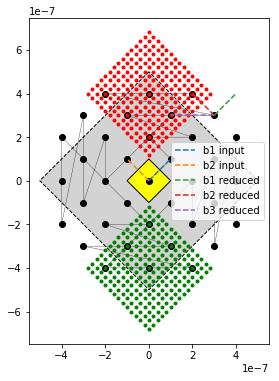

In [146]:
b1 = (bs,bs)
b2 = (-bs,bs)
#classifyLatticeSingle(b1,b2)
draw_and_classify(b1, b2)

(array([-59121380.93618385,  21272143.20735877]), array([-21272143.20735877, -59121380.93618385]))
(array([-59121380.93618385,  21272143.20735877]), array([-21272143.20735877, -59121380.93618385]))


<LatticeType.SQUARE: 4>

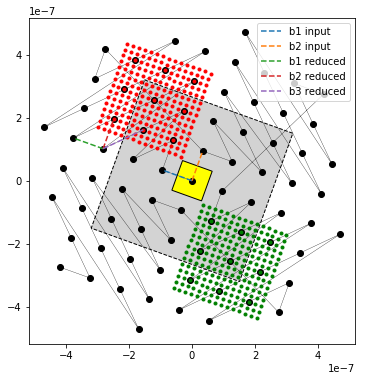

In [147]:
fi = np.random.rand() * 2*pi
b1 = (bs*sin(fi), bs*cos(fi))
b2 = (bs*cos(fi), -bs*sin(fi))
#classifyLatticeSingle(b1,b2)
draw_and_classify(b1, b2)

### Rectangular lattices

(array([       -0.        ,  62831853.07179586]), array([-57119866.42890532,        -0.        ]))
(array([-57119866.42890532,        -0.        ]), array([        0.        ,  62831853.07179586]))


<LatticeType.RECTANGULAR: 2>

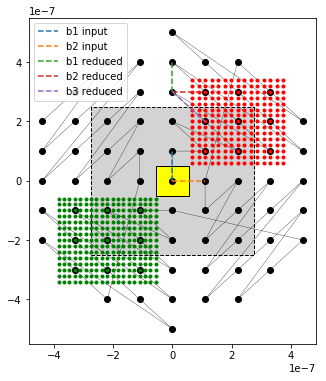

In [148]:
b1 = (0,bs)
b2 = (1.1*bs,0)
#classifyLatticeSingle(b1,b2)
draw_and_classify(b1, b2)

(array([ -1.57079633e+08,   1.57079633e+08]), array([-31415926.53589794, -31415926.53589794]))
(array([-31415926.53589794, -31415926.53589794]), array([ -1.57079633e+08,   1.57079633e+08]))


<LatticeType.RECTANGULAR: 2>

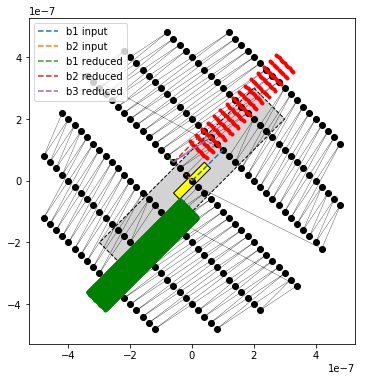

In [149]:
b1 = (bs,bs)
b2 = (-bs*.2,bs*.2)
#classifyLatticeSingle(b1,b2)
draw_and_classify(b1, b2)

(array([ -0.00000000e+00,   6.28318531e+08]), array([ -1.57079633e+08,  -0.00000000e+00]))
(array([ -1.57079633e+08,  -0.00000000e+00]), array([  0.00000000e+00,   6.28318531e+08]))


<LatticeType.RECTANGULAR: 2>

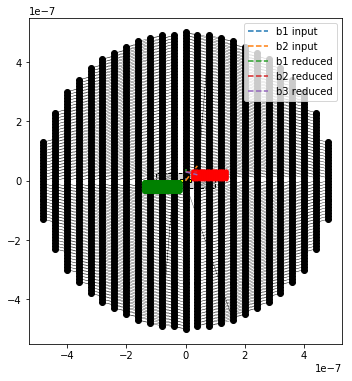

In [150]:
b1 = (0,.1*bs)
b2 = (.4*bs, .5*bs)
#classifyLatticeSingle(b1,b2)
draw_and_classify(b1, b2)

(array([ -1.02780135e+08,  -6.71834295e+07]), array([-34377892.59547352,  52592796.66579664]))
(array([-34377892.59547352,  52592796.66579664]), array([ -1.02780135e+08,  -6.71834295e+07]))


<LatticeType.RECTANGULAR: 2>

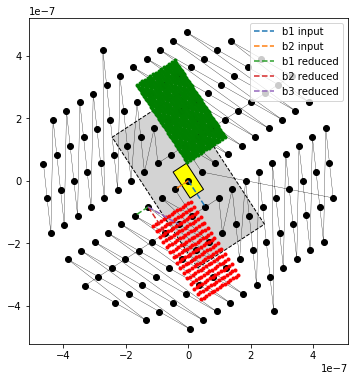

In [151]:
fi = np.random.rand() * 2*pi
fac = np.random.rand()  # For the "real" unit test, this may not be too near to one
b1 = (bs*sin(fi), bs*cos(fi))
b2 = (bs*cos(fi)*fac, -bs*sin(fi)*fac)
#classifyLatticeSingle(b1,b2)
draw_and_classify(b1, b2)

(array([ -1.02780135e+08,  -6.71834295e+07]), array([-34377892.59547352,  52592796.66579664]))
(array([-34377892.59547352,  52592796.66579664]), array([ -1.02780135e+08,  -6.71834295e+07]))


<LatticeType.RECTANGULAR: 2>

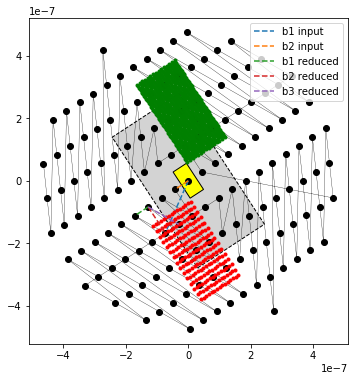

In [152]:
b1 = np.array(b1) + 3*np.array(b2)
#classifyLatticeSingle(b1,b2)
draw_and_classify(b1, b2)

### Equilateral triangular lattices

(array([-36275987.28468435,  62831853.07179586]), array([-72551974.56936871,        -0.        ]))
(array([-36275987.28468435,  62831853.07179586]), array([-72551974.56936871,        -0.        ]))


<LatticeType.EQUILATERAL_TRIANGULAR: 3>

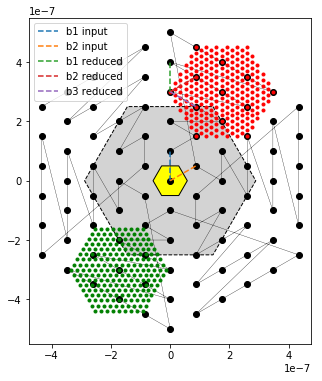

In [153]:
b1 = (0, bs)
b2 = (bs*s3/2, bs/2)
#classifyLatticeSingle(b1,b2)
draw_and_classify(b1, b2)

(array([ -2.60995242e+08,   3.08380654e+08]), array([  3.97563101e+08,   7.18381824e+07]))
(array([  3.97563101e+08,   7.18381824e+07]), array([ -2.60995242e+08,   3.08380654e+08]))


<LatticeType.EQUILATERAL_TRIANGULAR: 3>

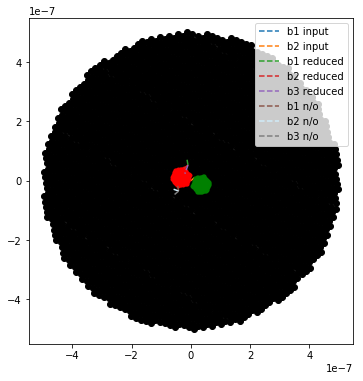

In [154]:
fi = np.random.rand() * 2*pi
fac = np.random.rand()  # For the "real" unit test, this may not be too near to one
b1 = (bs*sin(fi)*fac, bs*cos(fi)*fac)
b2 = (bs*sin(fi+2*pi/3)*fac, bs*cos(fi+2*pi/3)*fac)
#classifyLatticeSingle(b1,b2)
draw_and_classify(b1, b2)

(array([  3.97563101e+08,   7.18381824e+07]), array([  2.60995242e+08,  -3.08380654e+08]))
(array([  3.97563101e+08,   7.18381824e+07]), array([  2.60995242e+08,  -3.08380654e+08]))


<LatticeType.EQUILATERAL_TRIANGULAR: 3>

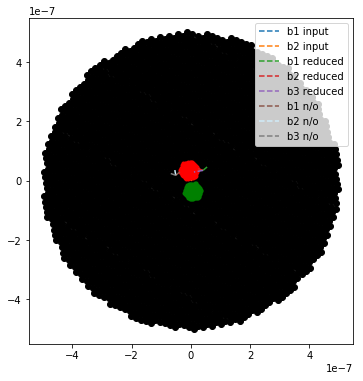

In [155]:
b1 = np.array(b1) + 3*np.array(b2)
#classifyLatticeSingle(b1,b2)
draw_and_classify(b1, b2)

### Rhombic lattices

(array([-31415926.53589794,  62831853.07179587]), array([-62831853.07179587,        -0.        ]))
(array([-62831853.07179587,        -0.        ]), array([-31415926.53589794,  62831853.07179587]))


<LatticeType.RHOMBIC: 5>

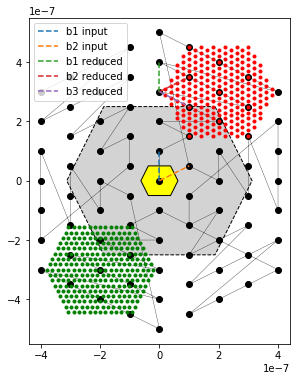

In [156]:
# case |b3| == |b2| > |b1|
b1 = (0,bs)
b2 = (bs, .5*bs)
#classifyLatticeSingle(b1,b2)
draw_and_classify(b1, b2)

(array([ 78539816.33974484,  62831853.07179587]), array([ 78539816.33974484, -62831853.07179587]))
(array([ 78539816.33974484,  62831853.07179587]), array([ 78539816.33974484, -62831853.07179587]))


<LatticeType.RHOMBIC: 5>

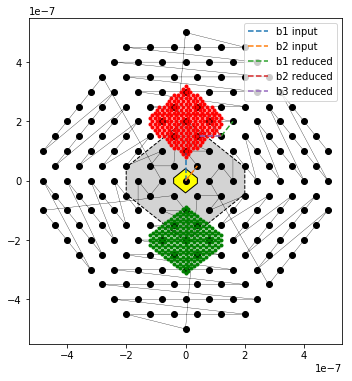

In [157]:
# case |b3| > |b2| == |b1|
b1 = (0,bs)
b2 = (.4*bs, .5*bs)
#classifyLatticeSingle(b1,b2)
draw_and_classify(b1, b2)

In [158]:
# TODO more

### Oblique lattices

(array([  5.37997742e+07,   6.28318531e+08]), array([ -1.57079633e+08,  -0.00000000e+00]))
(array([ -1.57079633e+08,   0.00000000e+00]), array([  5.37997742e+07,   6.28318531e+08]))


<LatticeType.OBLIQUE: 1>

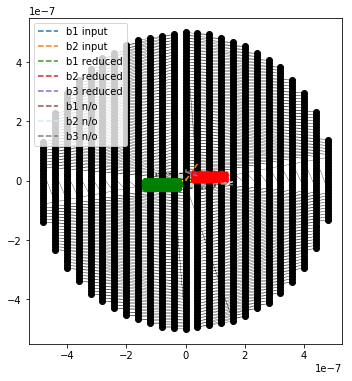

In [159]:
b1 = (0,.1*bs)
b2 = (.4*bs, .56575*bs)
#classifyLatticeSingle(b1,b2)
draw_and_classify(b1, b2)